## Data Visulization

##### Imoport the require package

In [1]:
from pyspark.sql import SparkSession
from os.path import abspath
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes

In [2]:
BASE_PATH = 'hdfs://localhost:8020/user'
CLEANED_PATH = f'{BASE_PATH}/hadoop/cleaned'
HIVE_DIR = 'hive/warehouse'
HIVE_LOCATION = f'{BASE_PATH}/{HIVE_DIR}'

In [4]:
from pyspark.sql import SparkSession

# Define the location of your Hive warehous

# Create a Spark session with Hive support
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .getOrCreate()

# Path to the CSV file on HDFS
file_path = f'{HIVE_LOCATION}/weather_data_partitioned_by_month'

# Read the CSV file into a DataFrame
df = spark.read.parquet(file_path, header=True)
df.show(5)

+----------+--------+-------------+---------------+----+-----------+----+----------+----------+--------------+---------+----------+
|      date|    time|water_content|solar_radiation|rain|temperature|  rh|wind_speed|gust_speed|wind_direction|dew_point|year_month|
+----------+--------+-------------+---------------+----+-----------+----+----------+----------+--------------+---------+----------+
|2020-11-01|00:00:00|       0.3062|            1.0| 0.0|      26.84|94.8|       0.3|       1.0|         152.0|    25.97|   2020-11|
|2020-11-01|00:05:00|       0.3066|            1.0| 0.0|      26.77|94.7|       0.0|       1.0|         152.0|    25.88|   2020-11|
|2020-11-01|00:10:00|       0.3066|            1.0| 0.0|      26.72|94.7|       0.3|       1.3|         154.0|    25.83|   2020-11|
|2020-11-01|00:15:00|       0.3066|            1.0| 0.0|      26.65|94.6|       0.0|       0.0|         152.0|    25.74|   2020-11|
|2020-11-01|00:20:00|       0.3066|            1.0| 0.0|      26.55|94.7|   

25/02/01 22:58:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content: float (nullable = true)
 |-- solar_radiation: float (nullable = true)
 |-- rain: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- rh: float (nullable = true)
 |-- wind_speed: float (nullable = true)
 |-- gust_speed: float (nullable = true)
 |-- wind_direction: float (nullable = true)
 |-- dew_point: float (nullable = true)
 |-- year_month: string (nullable = true)



In [6]:
df = df.toPandas()

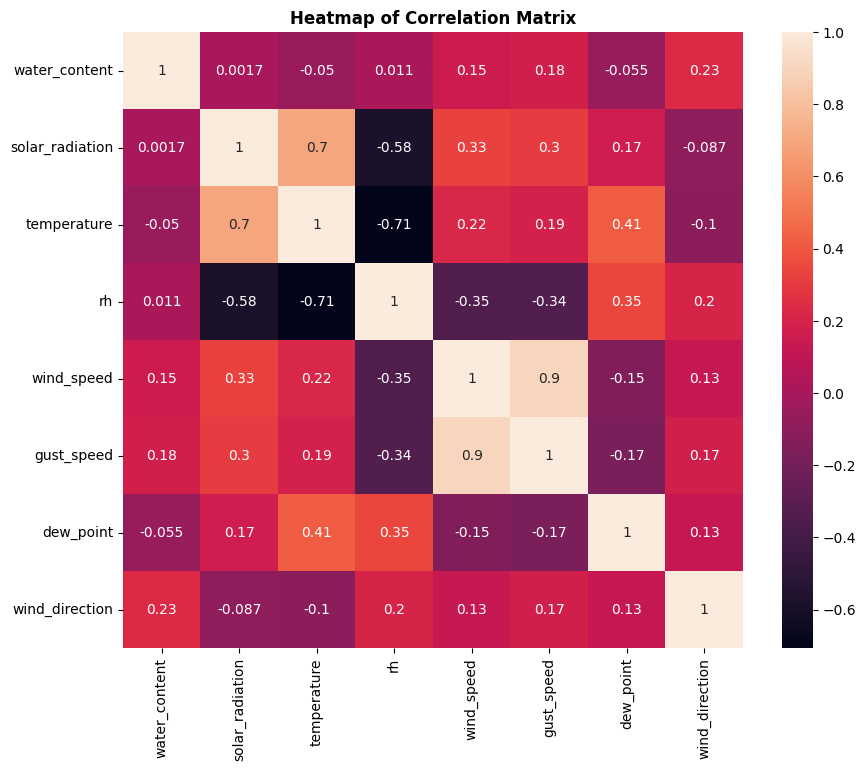

In [7]:
numeric_columns = ["water_content", "solar_radiation", "temperature", "rh", "wind_speed", "gust_speed", "dew_point","wind_direction"]
plt.figure(figsize=(10, 8))
correlation = df[numeric_columns].corr()
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True)
plt.title('Heatmap of Correlation Matrix', fontweight='bold')
plt.show()


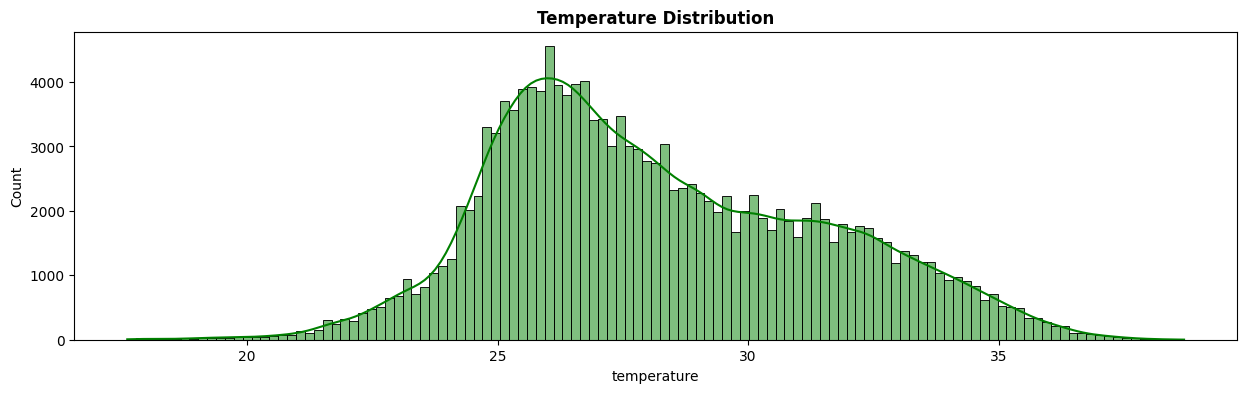

In [8]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 4))

# Temperature
sns.histplot(df.temperature, kde=True, color="g").set_title('Temperature Distribution')

plt.title("Temperature Distribution", fontweight='bold')
plt.show()


In [9]:
solar_tem = df[['time', 'solar_radiation', 'temperature']].copy()

solar_tem['shift'] = solar_tem['solar_radiation'].apply(lambda x: "Night" if x == 1 else "Day")

print(solar_tem)


            time  solar_radiation  temperature  shift
0       00:00:00              1.0    26.840000  Night
1       00:05:00              1.0    26.770000  Night
2       00:10:00              1.0    26.719999  Night
3       00:15:00              1.0    26.650000  Night
4       00:20:00              1.0    26.549999  Night
...          ...              ...          ...    ...
154632  22:35:00              1.0    26.430000  Night
154633  22:40:00              1.0    26.480000  Night
154634  22:45:00              1.0    26.379999  Night
154635  22:50:00              1.0    26.230000  Night
154636  00:00:00              1.0    25.209999  Night

[154637 rows x 4 columns]


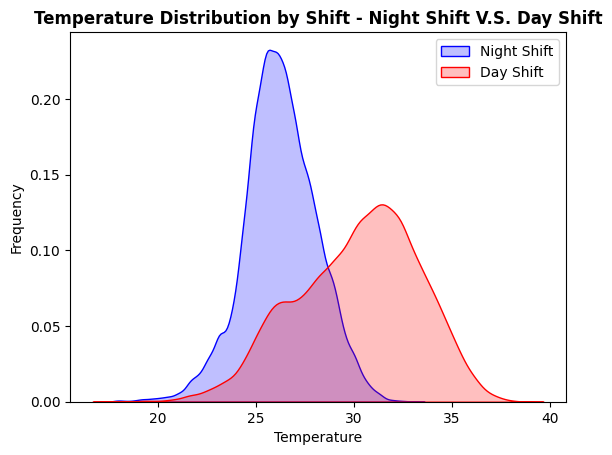

In [10]:
ax = sns.kdeplot(
    solar_tem.loc[solar_tem['shift'] == "Night", 'temperature'],
    color='b',
    fill=True, 
    label='Night Shift'
)
ax = sns.kdeplot(
    solar_tem.loc[solar_tem['shift'] == "Day", 'temperature'],
    color='r',
    fill=True,
    label='Day Shift'
)
ax.set(xlabel='Temperature', ylabel='Frequency')
plt.legend()
plt.title('Temperature Distribution by Shift - Night Shift V.S. Day Shift', fontweight='bold')
plt.show()


##### Show the unique year in our dataframe

In [11]:
df['date'] = pd.to_datetime(df['date'])

unique_years = df['date'].dt.year.unique()
unique_years.sort()
print(unique_years)

[2020 2021 2022]


##### Classify the wind pattern as windrose by each years 

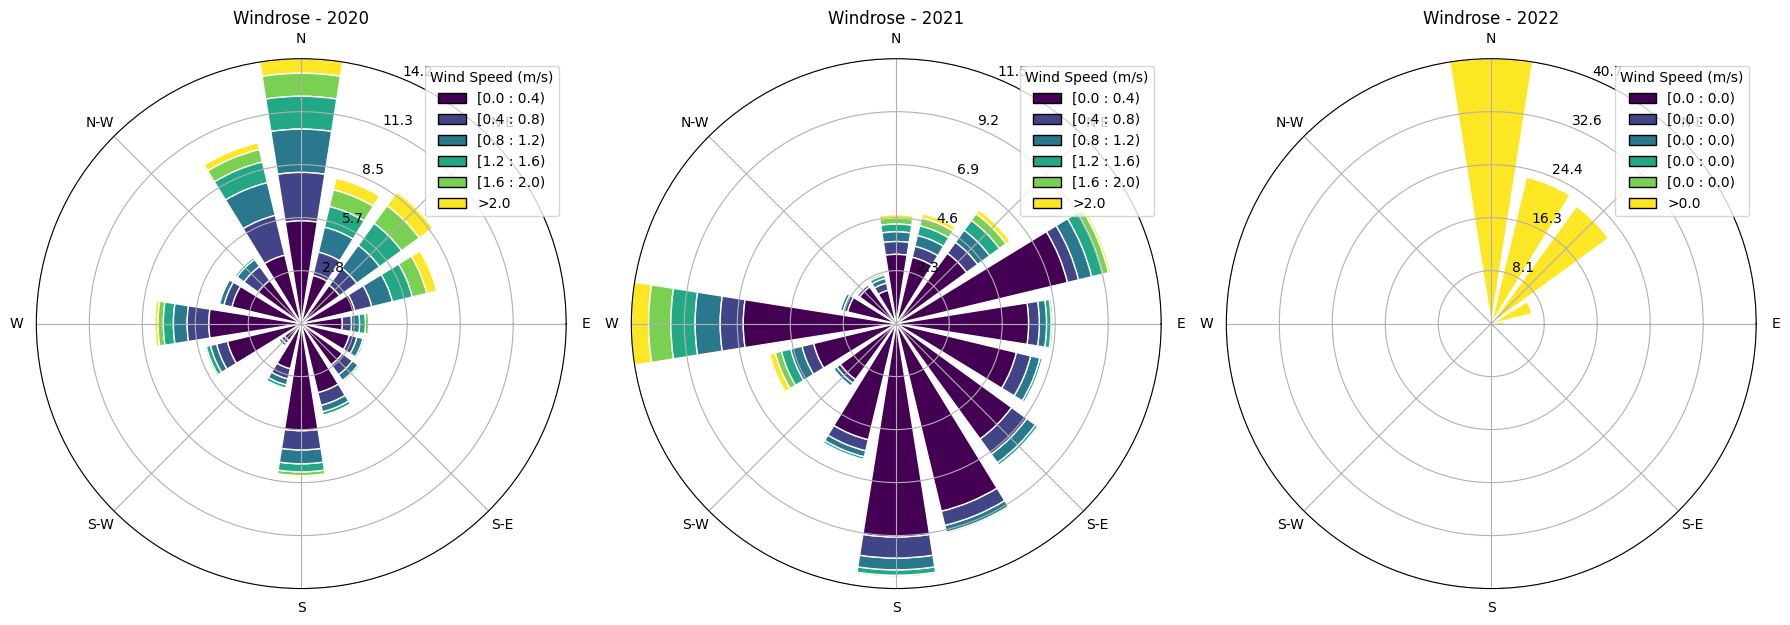

In [12]:
df['date'] = pd.to_datetime(df['date']) 
df['year'] = df['date'].dt.year

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection='windrose'), figsize=(18, 6))

for i, year in enumerate(unique_years):
    specific_year_df = df[df['year'] == year]
    
    wind_speed = specific_year_df['wind_speed']
    wind_direction = specific_year_df['wind_direction']
    
    ax = axes[i]
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f"Windrose - {year}", fontsize=12)
    ax.legend(title="Wind Speed (m/s)", loc="best")

plt.tight_layout()
plt.show()

##### Plot each month in 2020

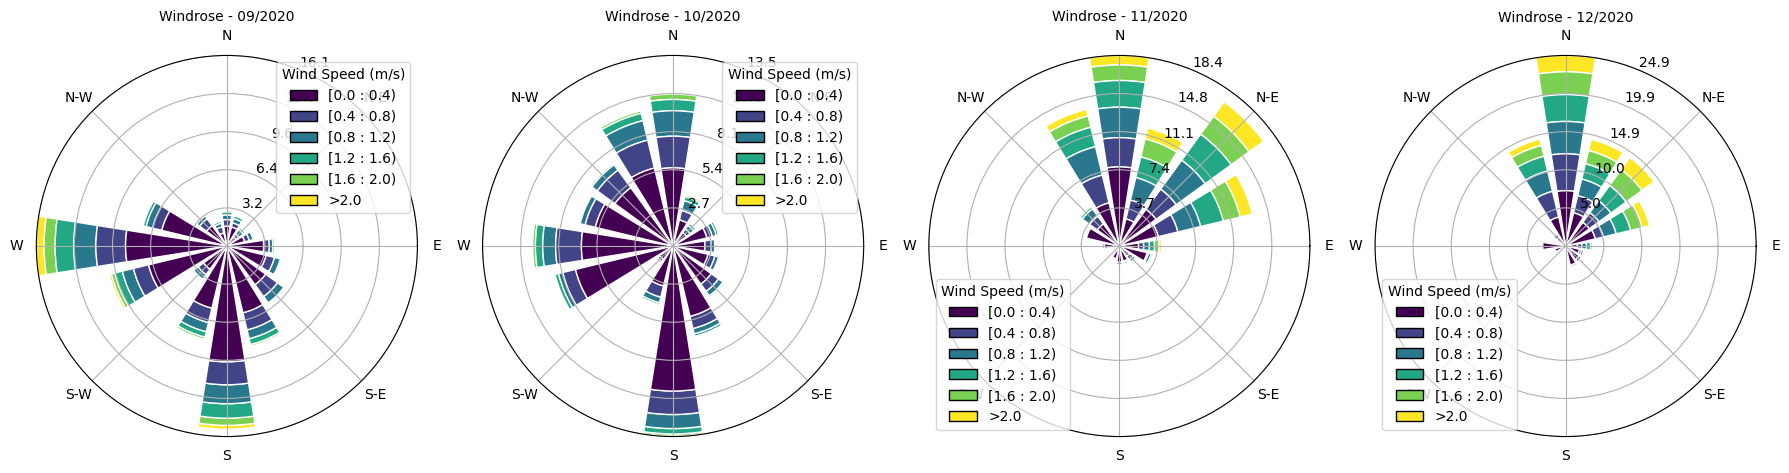

In [13]:


# Assuming 'df' is your DataFrame
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime
df['year'] = df['date'].dt.year          # Extract year
df['month'] = df['date'].dt.month        # Extract month

# Filter data for the year 2020
df_2020 = df[df['year'] == 2020]

# Get the unique months in the dataset
unique_months = sorted(df_2020['month'].unique())

# Determine the number of unique months
n_months = len(unique_months)

n_rows = (n_months + 3) // 4 
fig, axes = plt.subplots(n_rows, 4, subplot_kw=dict(projection='windrose'), figsize=(18, 6 * n_rows))

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate over the unique months
for i, month in enumerate(unique_months):
    # Filter data for the specific month
    specific_month_df = df_2020[df_2020['month'] == month]
    
    # Extract wind speed and direction
    wind_speed = specific_month_df['wind_speed']
    wind_direction = specific_month_df['wind_direction']
    
    # Plot the windrose for this month
    ax = axes[i]
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f"Windrose - {month:02d}/2020", fontsize=10)
    ax.legend(title="Wind Speed (m/s)", loc="best")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


##### Plot each month in 2021

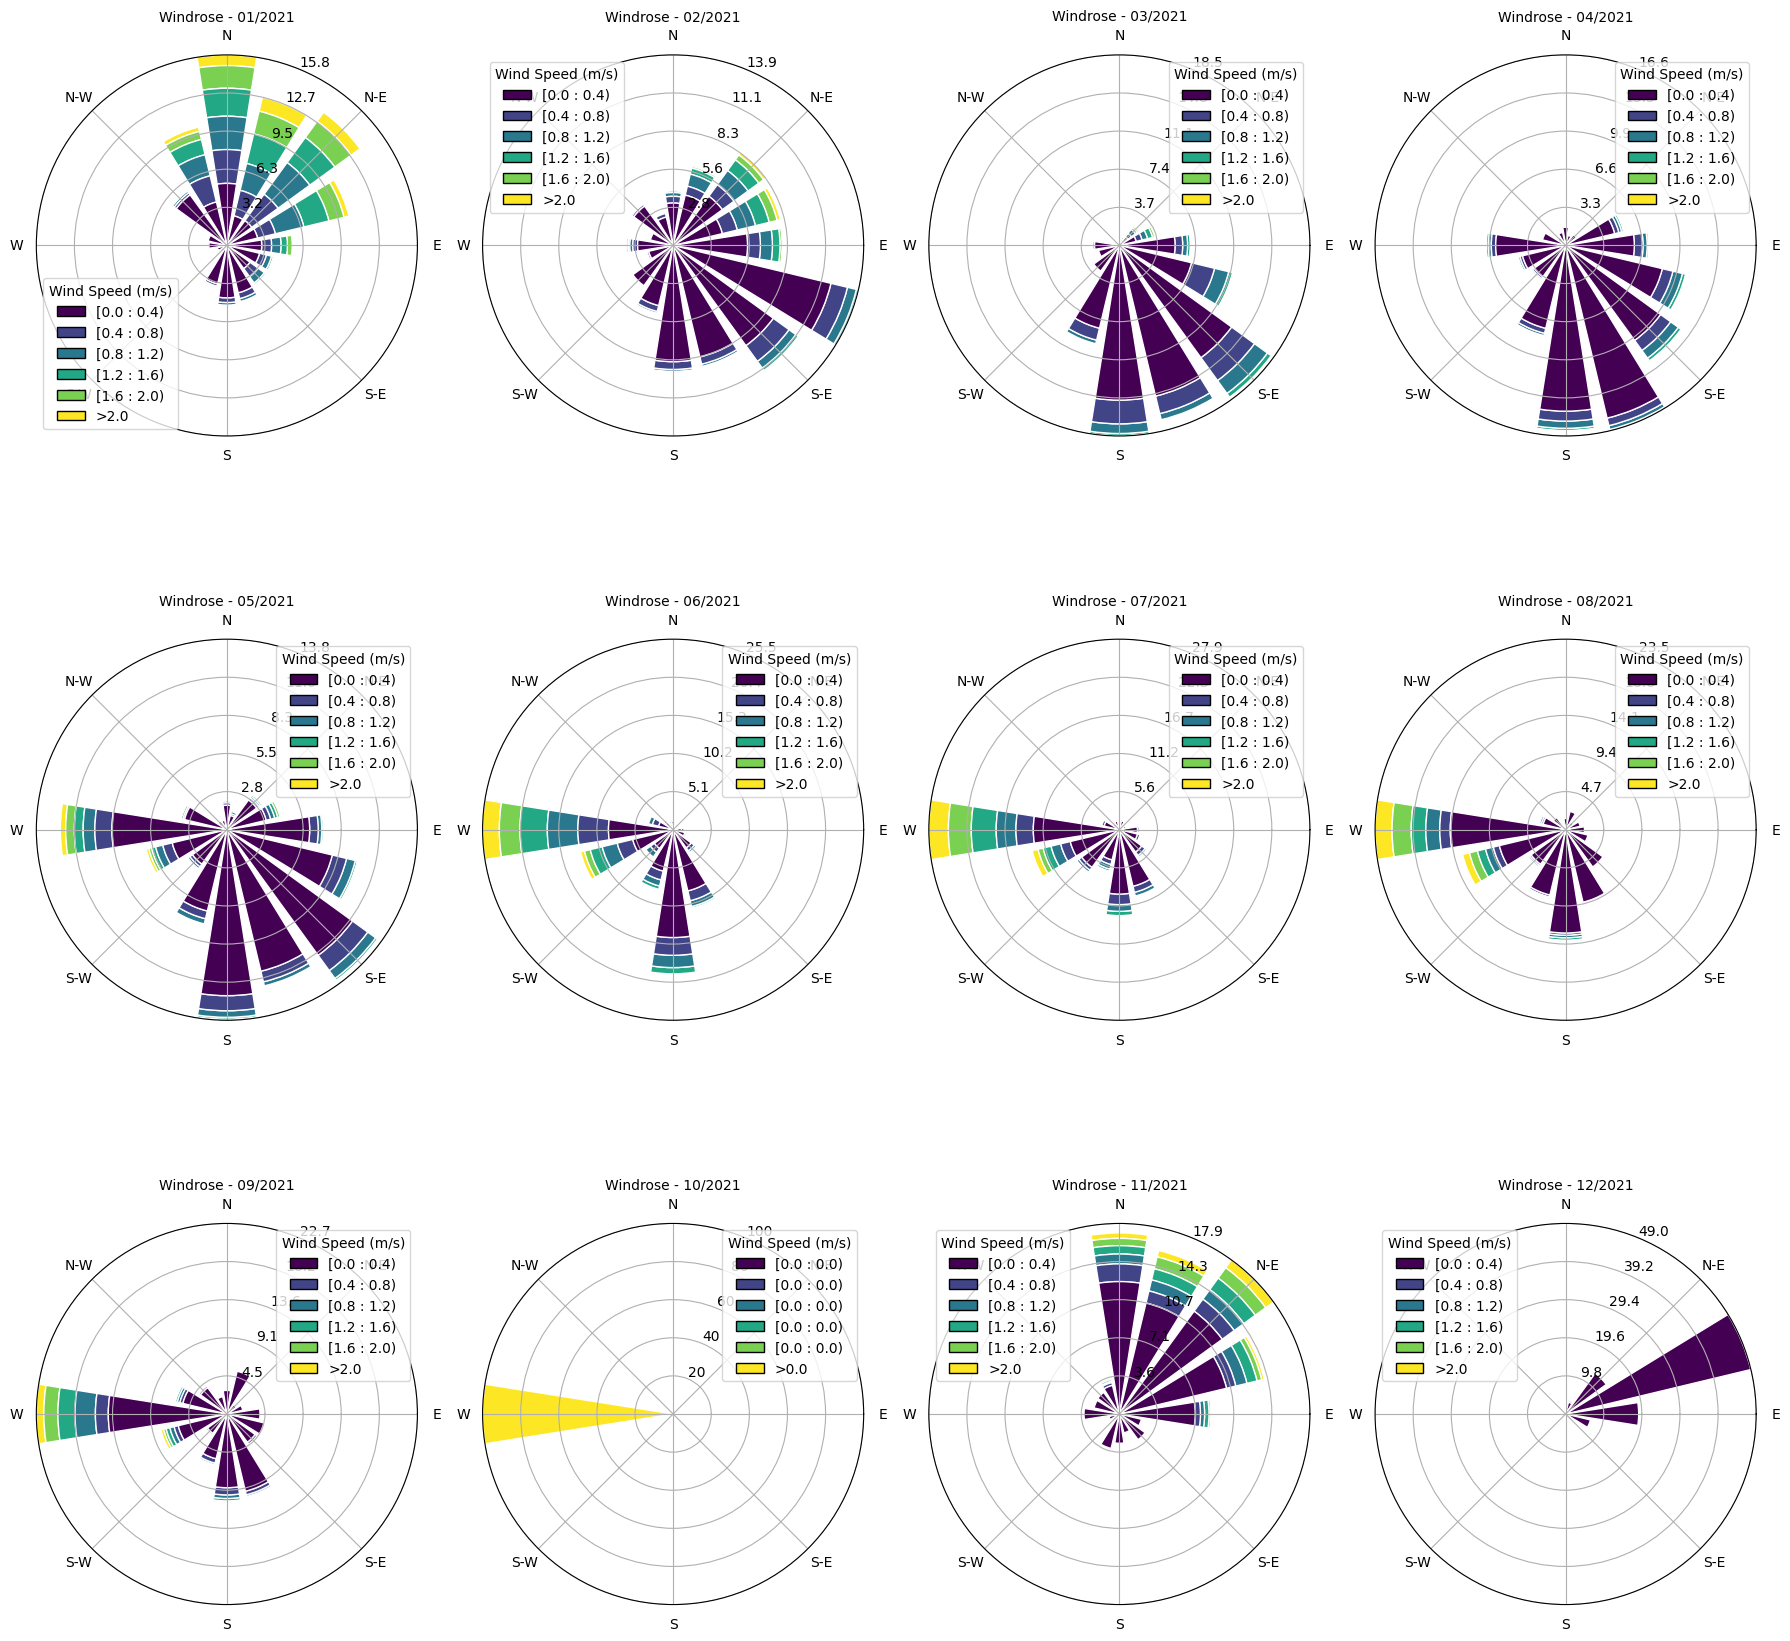

In [14]:

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month    

df_2021 = df[df['year'] == 2021]

unique_months = sorted(df_2021['month'].unique())

n_months = len(unique_months)

n_rows = (n_months + 3) // 4 
fig, axes = plt.subplots(n_rows, 4, subplot_kw=dict(projection='windrose'), figsize=(18, 6 * n_rows))

axes = axes.flatten()

for i, month in enumerate(unique_months):
    specific_month_df = df_2021[df_2021['month'] == month]
    
    wind_speed = specific_month_df['wind_speed']
    wind_direction = specific_month_df['wind_direction']
    
    ax = axes[i]
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f"Windrose - {month:02d}/2021", fontsize=10)
    ax.legend(title="Wind Speed (m/s)", loc="best")
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


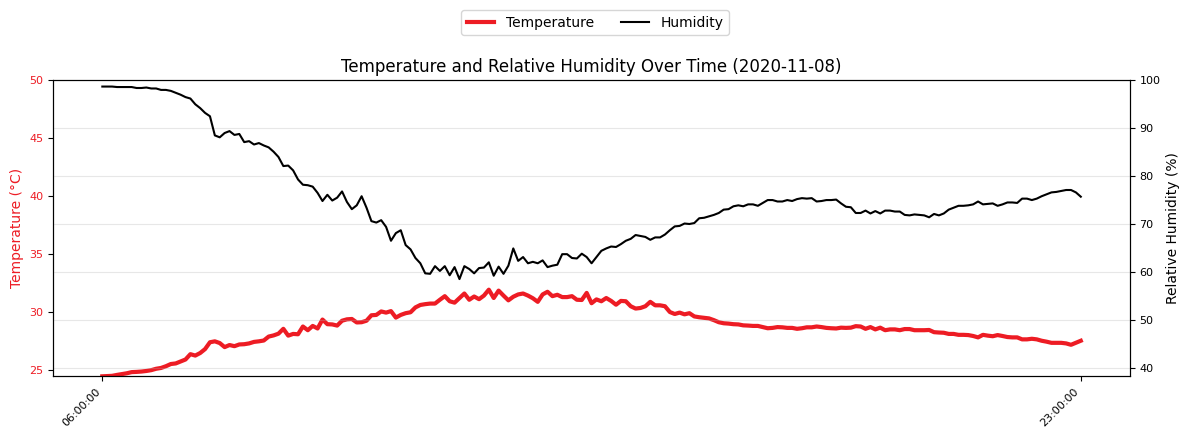

In [ ]:

testdate = "2020-12-08"

# Filter the DataFrame for the specific date and time range
specfic_date = df[(df['date'] == testdate) & (df['time'] >= "06:00:00") & (df['time'] <= "23:00:00")]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot temperature
ax.plot(specfic_date['time'], specfic_date['temperature'], color=(0.93, 0.11, 0.14), linewidth=3, label='Temperature')
ax.set_ylim(specfic_date['temperature'].min(), 50)
ax.set_ylabel("Temperature (°C)", fontsize=10, color=(0.93, 0.11, 0.14))
ax.tick_params(axis='y', labelsize=8, labelcolor=(0.93, 0.11, 0.14))

# Plot humidity on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(specfic_date['time'], specfic_date['rh'], color="black", linewidth=1.5, label='Humidity')
ax2.set_ylim(df['rh'].min(), 100)
ax2.set_ylabel("Relative Humidity (%)", fontsize=10, color="black")
ax2.tick_params(axis='y', labelsize=8, labelcolor="black")

# Set x-axis ticks to display only the start and end of the time range
start_time = "06:00:00"
end_time = "23:00:00"
ax.set_xticks([start_time, end_time])
ax.set_xticklabels([start_time, end_time], fontsize=8, rotation=45, ha='right')

# Title and legend
plt.title(f'Temperature and Relative Humidity Over Time ({testdate})', fontsize=12)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

# Adjust layout
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group by year and month, then calculate the mean for wind_speed and gust_speed
wind_by_year_month = (
    df.groupby(['year', 'month'])
    .agg(
        Avg_Wind_Speed=('wind_speed', 'mean'),
        Avg_Gust_Speed=('gust_speed', 'mean')
    )
    .reset_index()
    .sort_values(by=['year', 'month'])
)

print(wind_by_year_month)

    year  month  Avg_Wind_Speed  Avg_Gust_Speed
0   2020      9        0.427969        1.345078
1   2020     10        0.349408        1.229594
2   2020     11        0.745696        2.144961
3   2020     12        0.791121        2.417520
4   2021      1        0.665395        2.164838
5   2021      2        0.261207        1.105713
6   2021      3        0.254644        1.110088
7   2021      4        0.148855        0.738305
8   2021      5        0.230495        0.953319
9   2021      6        0.501943        1.587476
10  2021      7        0.428702        1.372148
11  2021      8        0.260972        0.810345
12  2021      9        0.222375        0.693045
13  2021     10        0.000000        0.000000
14  2021     11        0.290271        1.122860
15  2021     12        0.040801        0.179849
16  2022      1        0.000000        0.000000
17  2022      2        0.000000        0.000000
18  2022      3        0.000000        0.000000
19  2022      4        0.000000        0

##### Monthly Temperature Variation

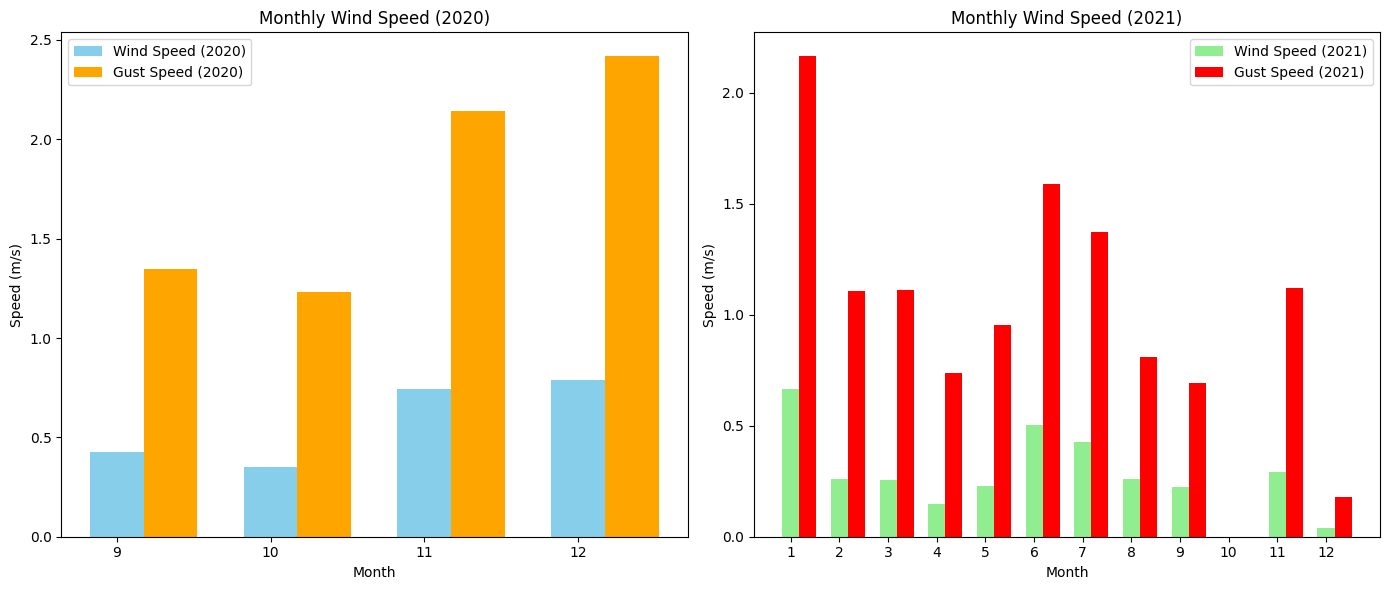

In [17]:
plt.figure(figsize=(14, 6))

# Plot for 2020
plt.subplot(1, 2, 1)
wind_2020 = wind_by_year_month[wind_by_year_month['year'] == 2020]
width = 0.35
plt.bar(wind_2020['month'], wind_2020['Avg_Wind_Speed'], width, label='Wind Speed (2020)', color='skyblue')
plt.bar(wind_2020['month'] + width, wind_2020['Avg_Gust_Speed'], width, label='Gust Speed (2020)', color='orange')
plt.title('Monthly Wind Speed (2020)')
plt.xlabel('Month')
plt.ylabel('Speed (m/s)')
plt.xticks(wind_2020['month'])
plt.legend()

# Plot for 2021
plt.subplot(1, 2, 2)
wind_2021 = wind_by_year_month[wind_by_year_month['year'] == 2021]
plt.bar(wind_2021['month'], wind_2021['Avg_Wind_Speed'], width, label='Wind Speed (2021)', color='lightgreen')
plt.bar(wind_2021['month'] + width, wind_2021['Avg_Gust_Speed'], width, label='Gust Speed (2021)', color='red')
plt.title('Monthly Wind Speed (2021)')
plt.xlabel('Month')
plt.ylabel('Speed (m/s)')
plt.xticks(wind_2021['month'])
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group by year and month, then calculate the mean for wind_speed and gust_speed
tem_by_year_month = (
    df.groupby(['year', 'month'])
    .agg(
        Avg_Temperature=('temperature', 'mean'),
    )
    .reset_index()
    .sort_values(by=['year', 'month'])
)

print(wind_by_year_month)

    year  month  Avg_Wind_Speed  Avg_Gust_Speed
0   2020      9        0.427969        1.345078
1   2020     10        0.349408        1.229594
2   2020     11        0.745696        2.144961
3   2020     12        0.791121        2.417520
4   2021      1        0.665395        2.164838
5   2021      2        0.261207        1.105713
6   2021      3        0.254644        1.110088
7   2021      4        0.148855        0.738305
8   2021      5        0.230495        0.953319
9   2021      6        0.501943        1.587476
10  2021      7        0.428702        1.372148
11  2021      8        0.260972        0.810345
12  2021      9        0.222375        0.693045
13  2021     10        0.000000        0.000000
14  2021     11        0.290271        1.122860
15  2021     12        0.040801        0.179849
16  2022      1        0.000000        0.000000
17  2022      2        0.000000        0.000000
18  2022      3        0.000000        0.000000
19  2022      4        0.000000        0

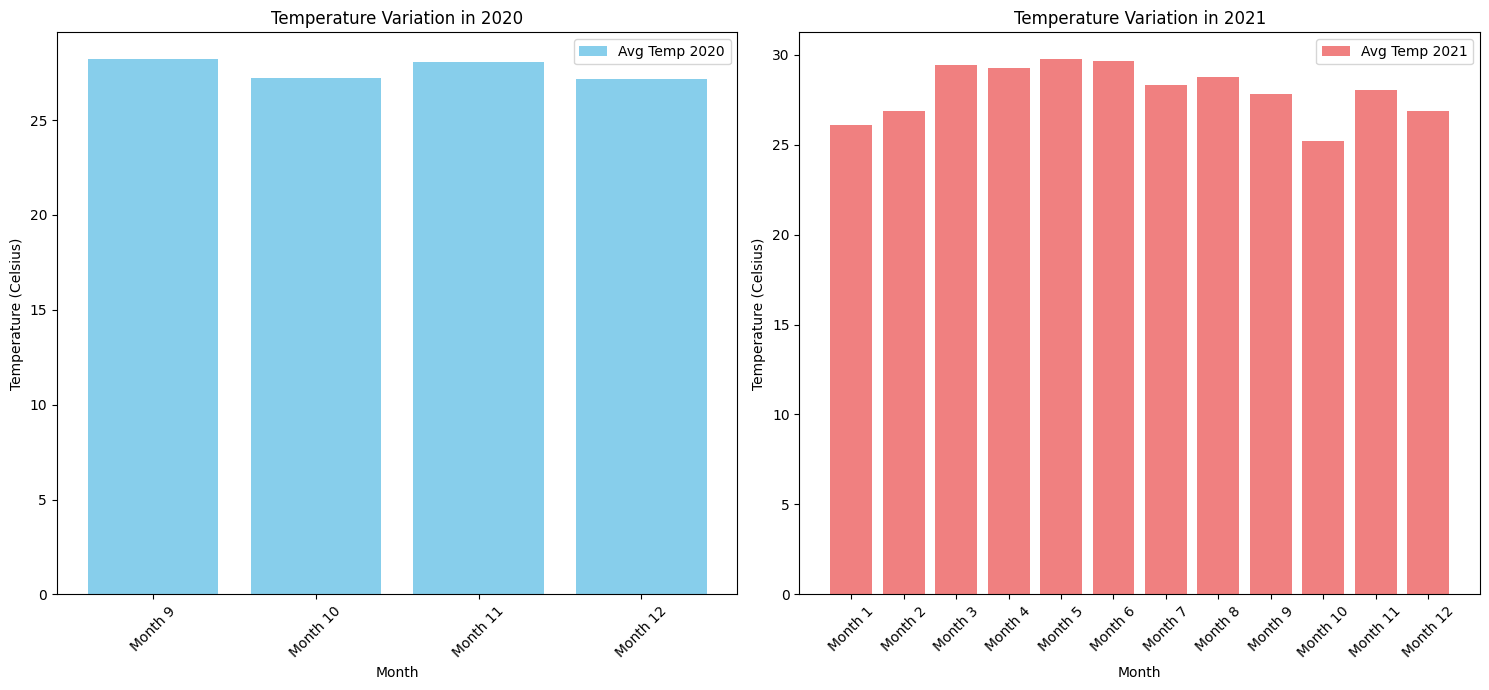

In [19]:
plt.figure(figsize=(15, 7))

# Plot for 2020
plt.subplot(1, 2, 1)
year_2020 = tem_by_year_month[tem_by_year_month['year'] == 2020]

if not year_2020.empty:
    plt.bar(year_2020['month'], year_2020['Avg_Temperature'], color='skyblue', label='Avg Temp 2020')
    plt.title('Temperature Variation in 2020')
    plt.xlabel('Month')
    plt.ylabel('Temperature (Celsius)')
    plt.xticks(year_2020['month'], labels=[f'Month {m}' for m in year_2020['month']], rotation=45)
    plt.legend()
else:
    plt.title('No Data for 2020')

# Plot for 2021
plt.subplot(1, 2, 2)
year_2021 = tem_by_year_month[tem_by_year_month['year'] == 2021]

if not year_2021.empty:
    plt.bar(year_2021['month'], year_2021['Avg_Temperature'], color='lightcoral', label='Avg Temp 2021')
    plt.title('Temperature Variation in 2021')
    plt.xlabel('Month')
    plt.ylabel('Temperature (Celsius)')
    plt.xticks(year_2021['month'], labels=[f'Month {m}' for m in year_2021['month']], rotation=45)
    plt.legend()
else:
    plt.title('No Data for 2021')

plt.tight_layout()
plt.show()


##### select only date and temperature 

In [20]:
tem = df[['date', 'temperature']]
tem.tail()

,date,temperature
154632,2020-12-03,26.430000
154633,2020-12-03,26.480000
154634,2020-12-03,26.379999
154635,2020-12-03,26.230000
154636,2021-10-01,25.209999


In [21]:
tem = tem.groupby(['date'])['temperature'].mean()
tem = pd.DataFrame(tem)
tem.head()

,temperature
date,
2020-09-01,27.922464
2020-09-02,27.288849
2020-09-03,28.490452
2020-09-04,29.702847
2020-09-05,30.362083


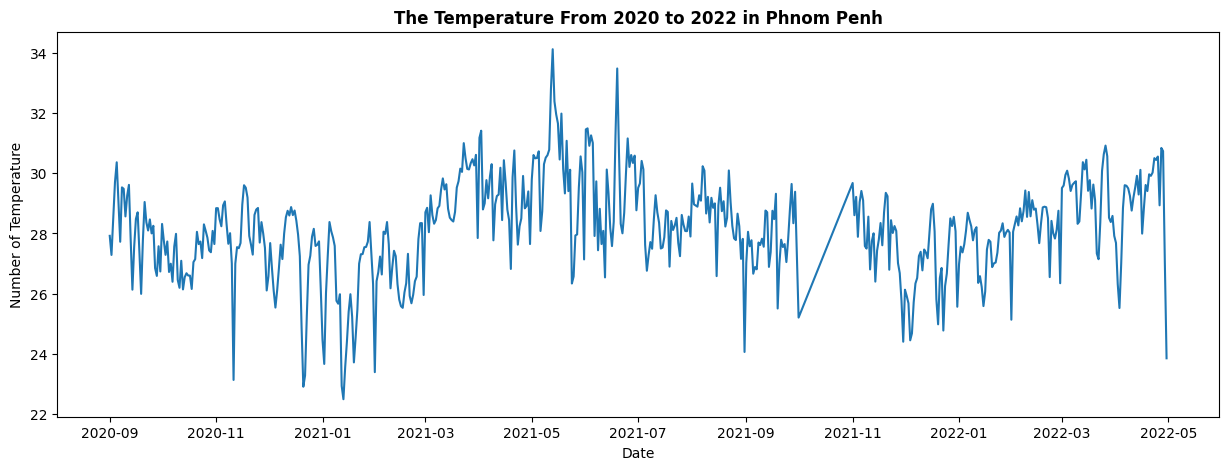

In [22]:
plt.figure(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Number of Temperature')
plt.title('The Temperature From 2020 to 2022 in Phnom Penh', fontweight='bold')
plt.plot(tem)
plt.show()

In [24]:
tem['month'] = tem.index.month
tem['year'] = tem.index.year
pivot = pd.pivot_table(tem, values='temperature', index='month', columns='year', aggfunc='mean')
max_tem_monthly = pivot.groupby("month").max()
min_tem_monthly = pivot.groupby("month").min()

monthly_seasonality = pivot.mean(axis=1)
max_monthly_seasonality = max_tem_monthly.max(axis=1)
min_tem_monthly = min_tem_monthly.min(axis=1)

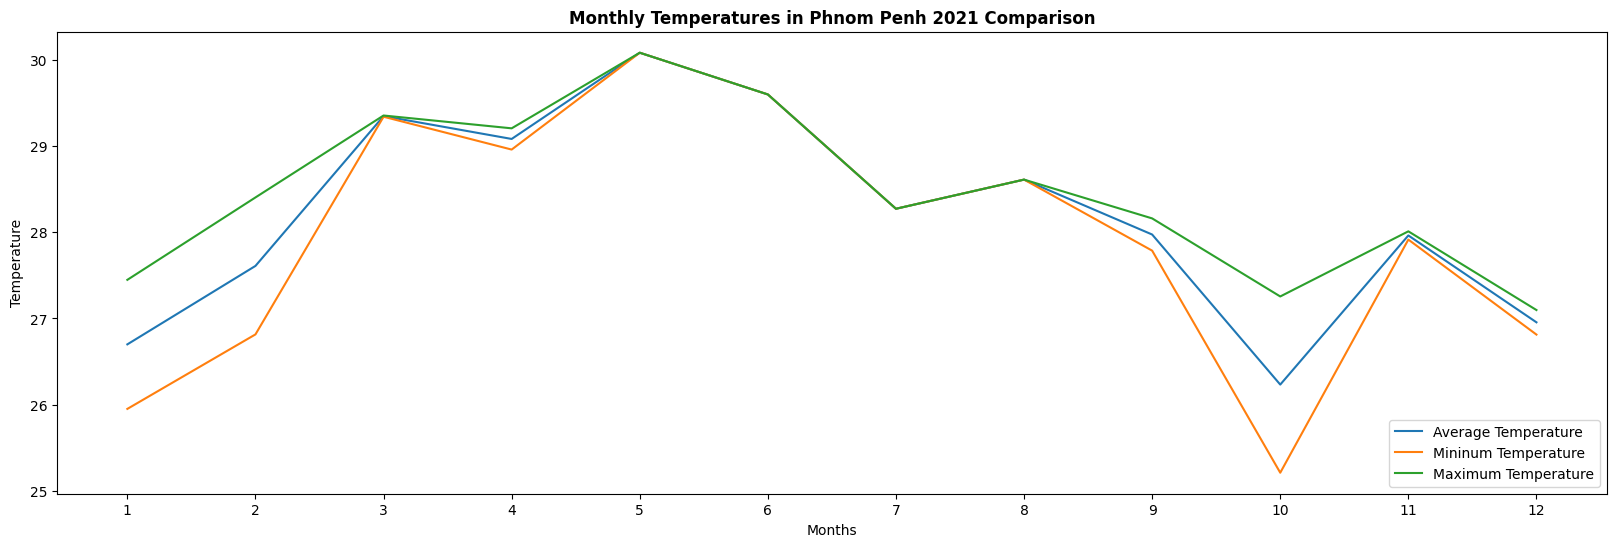

In [25]:
#select all the case in one plot 

#average 
monthly_seasonality.plot(figsize=(20,6), legend="Average Temperature")
#min
min_tem_monthly.plot(figsize=(20,6), legend="Mininum Temperature")
#max
max_monthly_seasonality.plot(figsize=(20,6), legend="Maximum Temperature")

plt.title('Monthly Temperatures in Phnom Penh 2021 Comparison', fontweight='bold')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.legend(["Average Temperature", "Mininum Temperature", "Maximum Temperature"], loc ="lower right")
plt.xticks([x for x in range(1,13)])
plt.show()